# **Overview / Objective**

- Implemented LSM (Lower Bound) and BA (Upper Bound) for American Put Option Pricing
- Compared Stability of 4 regression methods: Polynomial, BS basis, Piecewise, and Kernel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from IPython.display import display, Markdown
import wrds
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)

# **SetUp**
- Define Black-Scholes MC path generator and pricing functions
- Set benchmark parameters: S0=100, K=100, vol=0.2, r=0.1, q=0.02, T=1
- Time grid: 12 monthly steps (13 points including t=0)

In [2]:
def blackscholes_mc(S=100, vol=0.2, r=0, q=0, ts=np.linspace(0, 1, 13), npaths=10):
    """Generate Monte-Carlo paths in Black-Scholes model.

    Parameters
    ----------
    S: scalar
        The spot price of the underlying security.
    vol: scalar
        The implied Black-Scholes volatility.
    r: scalar
        The annualized risk-free interest rate, continuously compounded.
    q: scalar
        The annualized continuous dividend yield.
    ts: array_like
        The time steps of the simualtion
    npaths: int
        the number of paths to simulate

    Returns
    -------
    paths: ndarray
        The Monte-Carlo paths.
    """
    nsteps = len(ts) - 1
    ts = np.asarray(ts)[:, np.newaxis]
    W = np.cumsum(np.vstack((np.zeros((1, npaths), dtype=float),
                             np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts, axis=0)))),
                  axis=0)
    paths = np.exp(-0.5*vol**2*ts + vol*W)*S*np.exp((r-q)*ts)
    return paths


def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in the Black-Scholes model

    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option, expressed in years (e.g. 0.25 for 3-month and 2 for 2 years)
    S: scalar or array_like
        The current price of the underlying asset.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    r: scalar or array_like
        The annualized risk-free interest rate, continuously compounded.
    q: scalar or array_like
        The annualized continuous dividend yield.
    callput: str
        Must be either 'call' or 'put'.

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S*np.exp((r-q)*T)
    v = np.sqrt(vol**2*T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

In [3]:
S0 = 100
K = 100
vol = 0.2
r = 0.1
q = 0.02
T = 1

ts = np.linspace(0, T, 13)

def payoff(S):
    return np.maximum(K - S, 0)

# **Regression**

In [4]:
# regression: polynomial

def regression_polynomial(X, Y, S_current, degree=3, **kwargs):

    coeffs = np.polyfit(X, Y, deg=degree)
    cont_value = np.polyval(coeffs, S_current)
    model = {
        'type': 'polynomial',
        'coeffs': coeffs,
        'degree': degree
    }

    return cont_value, model

In [5]:
# regression: bs

def regression_bs_basis(X, Y, S_current, K, r, tau, vol=0.2, q=0, **kwargs):
    Z_train = blackscholes_price(K, tau, X, vol, r, q, callput='put')

    A = np.vstack([np.ones(len(Z_train)), Z_train]).T
    beta = np.linalg.lstsq(A, Y, rcond=None)[0]

    Z_current = blackscholes_price(K, tau, S_current, vol, r, q, callput='put')
    cont_value = beta[0] + beta[1] * Z_current

    model = {
        'type': 'bs_basis',
        'beta': beta,
        'vol': vol,
        'q': q,
        'tau': tau
    }

    return cont_value, model

In [6]:
# regression: bs_extended

def regression_bs_extended(X, Y, S_current, K, r, tau, vol=0.2, q=0, **kwargs):
    Z_train = blackscholes_price(K, tau, X, vol, r, q, callput='put')

    F = X * np.exp((r-q)*tau)
    v = np.sqrt(vol**2 * tau)
    d1 = np.log(F/K)/v + 0.5*v
    delta_train = norm.cdf(d1) - 1

    A = np.vstack([np.ones(len(Z_train)), Z_train, delta_train]).T
    beta = np.linalg.lstsq(A, Y, rcond=None)[0]

    Z_current = blackscholes_price(K, tau, S_current, vol, r, q, callput='put')
    F_current = S_current * np.exp((r-q)*tau)
    d1_current = np.log(F_current/K)/v + 0.5*v
    delta_current = norm.cdf(d1_current) - 1

    cont_value = beta[0] + beta[1] * Z_current + beta[2] * delta_current

    model = {
        'type': 'bs_basis_extended',
        'beta': beta,
        'vol': vol,
        'q': q,
        'tau': tau
    }

    return cont_value, model

In [39]:
# regression: piecewise

def regression_piecewise(X, Y, S_current, n_knots=10, **kwargs):
    knots = np.percentile(X, np.linspace(0, 100, n_knots+1))

    segment = np.searchsorted(knots, S_current) - 1
    segment = np.clip(segment, 0, n_knots-1)

    cont_value = np.zeros_like(S_current, dtype=float)
    coeffs_list = []

    for i in range(n_knots):
        mask = (X >= knots[i]) & (X < knots[i+1])
        if i == n_knots-1:
            mask = (X >= knots[i]) & (X <= knots[i+1])

        if np.sum(mask) >= 2:
            X_seg = X[mask]
            Y_seg = Y[mask]
            coeffs = np.polyfit(X_seg, Y_seg, deg=1)
            coeffs_list.append(coeffs)

            current_mask = segment == i
            cont_value[current_mask] = np.polyval(coeffs, S_current[current_mask])
        else:
            coeffs_list.append(None)

    model = {
        'type': 'piecewise',
        'knots': knots,
        'coeffs_list': coeffs_list,
        'n_knots': n_knots
    }

    return cont_value, model

In [40]:
# regression: kernel

def regression_kernel(X, Y, S_current, bandwidth=10, **kwargs):
    batch_size = 1000
    cont_value = np.zeros(len(S_current), dtype=float)

    for start in range(0, len(S_current), batch_size):
        end = min(start + batch_size, len(S_current))
        batch = S_current[start:end]

        distances = batch[:, np.newaxis] - X[np.newaxis, :]
        weights = np.exp(-0.5 * (distances / bandwidth)**2)
        weights /= weights.sum(axis=1, keepdims=True)
        cont_value[start:end] = weights @ Y

    sample_size = min(2000, len(X))
    idx = np.random.choice(len(X), sample_size, replace=False)

    model = {
        'type': 'kernel',
        'bandwidth': bandwidth,
        'X': X[idx],
        'Y': Y[idx]
    }

    return cont_value, model


# **LSM / BA**

In [7]:
def ls_pricer(paths, K, r, ts, regression_func, **regression_params):
    n_steps, n_paths = paths.shape
    payoff = np.maximum(K - paths[-1], 0)

    exercise_policy = {
        'models': [],
        'ts': ts,
        'K': K,
        'r': r,
        'regression_func': regression_func,
        'regression_params': regression_params
    }

    for i in range(n_steps-2, 0, -1):
        discount = np.exp(-r * (ts[i+1] - ts[i]))
        payoff_discounted = payoff * discount

        exercise_value = np.maximum(K - paths[i], 0)

        X = paths[i]
        Y = payoff_discounted
        tau = ts[-1] - ts[i]

        cont_value, model = regression_func(
            X, Y, X,
            K=K, r=r, tau=tau,
            **regression_params
        )

        exercise_policy['models'].insert(0, model)

        exercise_mask = exercise_value > cont_value

        payoff_new = payoff_discounted.copy()
        payoff_new[exercise_mask] = exercise_value[exercise_mask]
        payoff = payoff_new

    price = np.mean(payoff * np.exp(-r * (ts[1] - ts[0])))

    return price, exercise_policy

In [8]:
exer_func = lambda S: np.maximum(K-S, 0)

In [9]:
n_train_basic = 10000
paths_train = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=n_train_basic)

price_lsm, policy = ls_pricer(paths_train, K, r, ts, regression_polynomial, degree=3)
models = policy['models']
V0 = price_lsm

In [10]:
def exer_or_cont(i, S, models, K, r, ts):

    S = np.atleast_1d(S)

    if i >= len(ts) - 1:
        return np.maximum(K - S, 0) > 0

    if i < 1 or i - 1 >= len(models):
        return np.zeros(len(S), dtype=bool)

    model = models[i - 1]
    exercise_value = np.maximum(K - S, 0)

    if model['type'] == 'polynomial':
        cont_value = np.polyval(model['coeffs'], S)

    elif model['type'] == 'bs_basis':
        tau = model['tau']
        Z = blackscholes_price(K, tau, S, model['vol'], r, model['q'], callput='put')
        cont_value = model['beta'][0] + model['beta'][1] * Z

    elif model['type'] == 'bs_basis_extended':
        tau = model['tau']
        Z = blackscholes_price(K, tau, S, model['vol'], r, model['q'], callput='put')
        F = S * np.exp((r - model['q'])*tau)
        v = np.sqrt(model['vol']**2 * tau)
        d1 = np.log(F/K)/v + 0.5*v
        delta = norm.cdf(d1) - 1
        cont_value = model['beta'][0] + model['beta'][1] * Z + model['beta'][2] * delta

    elif model['type'] == 'piecewise':
        knots = model['knots']
        coeffs_list = model['coeffs_list']
        n_knots = model['n_knots']
        segment = np.searchsorted(knots, S) - 1
        segment = np.clip(segment, 0, n_knots - 1)
        cont_value = np.zeros(len(S), dtype=float)
        for j in range(n_knots):
            mask = segment == j
            if coeffs_list[j] is not None and np.sum(mask) > 0:
                cont_value[mask] = np.polyval(coeffs_list[j], S[mask])

    elif model['type'] == 'kernel':
        distances = S[:, np.newaxis] - model['X'][np.newaxis, :]
        weights = np.exp(-0.5 * (distances / model['bandwidth'])**2)
        weights /= weights.sum(axis=1, keepdims=True)
        cont_value = weights @ model['Y']

    return exercise_value > cont_value

In [11]:
def nested_mc(S, vol, r, q, i, ts, nnested, models, K):
    nested_paths = np.full(nnested, S, dtype=float)
    tot_payoff = 0
    for j in range(i+1, len(ts)):
        dt = ts[j] - ts[j-1]
        dW = np.random.randn(len(nested_paths))*np.sqrt(dt)
        nested_paths = nested_paths*np.exp((r-q)*dt)*np.exp(-0.5*vol**2*dt + vol*dW)
        exer_vals = np.maximum(K - nested_paths, 0)
        if j < len(ts)-1:
            ind = exer_or_cont(j, nested_paths, models, K, r, ts)
            tot_payoff += np.sum(exer_vals[ind])*np.exp(-r*ts[j])
            nested_paths = nested_paths[~ind]
            if len(nested_paths) == 0:
                break
        else:
            tot_payoff += np.sum(exer_vals)*np.exp(-r*ts[j])
    return tot_payoff/nnested

In [12]:
price_lsm, policy = ls_pricer(paths_train, K, r, ts, regression_polynomial, degree=3)
models = policy['models']
V0 = price_lsm

npaths = 500
nnested = 1000
paths = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=npaths)
V = np.full(paths.shape, np.nan, dtype=float)
EV = np.full(paths.shape, np.nan, dtype=float)
V[0] = V0
EV[0] = V0
for i in range(1, len(ts)-1):
    exer_vals = exer_func(paths[i])
    ind = exer_or_cont(i, paths[i], models, K, r, ts)  
    for j in np.nonzero(ind)[0]:
        V[i, j] = exer_vals[j]*np.exp(-r*ts[i])
        EV[i,j] = nested_mc(paths[i, j], vol, r, q, i, ts, nnested, models, K) 
    for j in np.nonzero(~ind)[0]:
        V[i,j] = nested_mc(paths[i, j], vol, r, q, i, ts, nnested, models, K)
        EV[i, j] = V[i, j]
V[-1] = exer_func(paths[-1])*np.exp(-r*ts[-1])
hedges = np.zeros(paths.shape, dtype=float)
hedges[1:] = np.cumsum(V[1:]-EV[:-1], axis=0)

print('Lower Bound (LSM) = {:.4f}'.format(V0))
print('Upper Bound (BA)  = {:.4f}'.format(np.mean(np.amax(exer_func(paths[1:])*np.exp(-r*ts[1:, np.newaxis])-hedges[1:], axis=0))))

Lower Bound (LSM) = 5.0712
Upper Bound (BA)  = 5.1986


# **Convergence Test**
- Tested how lower/upper bounds converge as n_train increases
- Fixed seed(42) and Used polynomial regression (deg = 3)
- For each n_train, compute bounds and observe gap and validity


In [47]:
print("="*70)
print("CONVERGENCE TEST - Polynomial deg=3")
print("="*70)

np.random.seed(42)
n_train_list = [5000, 10000, 50000, 100000, 200000]

results_conv = []

for n_train_con in n_train_list:
    print(f"\nn_train = {n_train_con}...")

    np.random.seed(42)
    paths_train = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=n_train_con)

    price_lsm, policy = ls_pricer(paths_train, K, r, ts, regression_polynomial, degree=3)
    models = policy['models']

    paths_ba = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=npaths)
    V = np.full(paths_ba.shape, np.nan, dtype=float)
    EV = np.full(paths_ba.shape, np.nan, dtype=float)
    V[0] = price_lsm
    EV[0] = price_lsm

    for i in range(1, len(ts)-1):
        exer_vals = exer_func(paths_ba[i])
        ind = exer_or_cont(i, paths_ba[i], models, K, r, ts)
        for j in np.nonzero(ind)[0]:
            V[i, j] = exer_vals[j]*np.exp(-r*ts[i])
            EV[i,j] = nested_mc(paths_ba[i, j], vol, r, q, i, ts, nnested, models, K)
        for j in np.nonzero(~ind)[0]:
            V[i,j] = nested_mc(paths_ba[i, j], vol, r, q, i, ts, nnested, models, K)
            EV[i, j] = V[i, j]

    V[-1] = exer_func(paths_ba[-1])*np.exp(-r*ts[-1])
    hedges = np.zeros(paths_ba.shape, dtype=float)
    hedges[1:] = np.cumsum(V[1:]-EV[:-1], axis=0)

    upper = np.mean(np.amax(exer_func(paths_ba[1:])*np.exp(-r*ts[1:, np.newaxis])-hedges[1:], axis=0))

    valid = '✓' if price_lsm < 5.152 < upper else '✗'
    results_conv.append({
        'n_train': n_train_con,
        'lower': price_lsm,
        'upper': upper,
        'valid': valid
    })

    print(f"  Lower: {price_lsm:.4f}, Upper: {upper:.4f}, Valid: {valid}")

print("\n" + "="*70)
print(f"{'n_train':<12} {'Lower':<12} {'Upper':<12} {'Gap':<12} {'Valid'}")
print("-"*70)
for res in results_conv:
    gap = res['upper'] - res['lower']
    print(f"{res['n_train']:<12} {res['lower']:<12.4f} {res['upper']:<12.4f} {gap:<12.4f} {res['valid']}")
print("-"*70)
print(f"Reference: 5.152")
print("="*70)

CONVERGENCE TEST - Polynomial deg=3

n_train = 5000...
  Lower: 5.0452, Upper: 5.1228, Valid: ✗

n_train = 10000...
  Lower: 5.0712, Upper: 5.1986, Valid: ✓

n_train = 50000...
  Lower: 5.0739, Upper: 5.1720, Valid: ✓

n_train = 100000...
  Lower: 5.0936, Upper: 5.1858, Valid: ✓

n_train = 200000...
  Lower: 5.0972, Upper: 5.1921, Valid: ✓

n_train      Lower        Upper        Gap          Valid
----------------------------------------------------------------------
5000         5.0452       5.1228       0.0776       ✗
10000        5.0712       5.1986       0.1274       ✓
50000        5.0739       5.1720       0.0981       ✓
100000       5.0936       5.1858       0.0922       ✓
200000       5.0972       5.1921       0.0949       ✓
----------------------------------------------------------------------
Reference: 5.152


## Result for convergence test
- n_train = 5,000 showed invalid result (Upper < Reference)
- n_train over 10,000 all valid, but gap is slightly decreasing
- Gap converges to ~0.09 when n_train >= 50,000
- Decided to use n_train = 50,000 for later calculation

# **Stability Check**
- For each regression method, repeat pricing 20 times with fixed seed
- Each repetition uses different random paths
- Measure mean and std both for lower/upper bound
- Compare stability across different parameter choices within each method

# Polynomial - Stability Test

In [14]:
# POLYNOMIAL REGRESSION - STABILITY ANALYSIS

print("="*70)
print("POLYNOMIAL REGRESSION - STABILITY ANALYSIS")
print("="*70)

np.random.seed(42)
n_train = 50000
n_repeat = 20
degrees = [2, 3, 4, 5, 7, 10]

results_poly = {deg: {'lower': [], 'upper': []} for deg in degrees}

for deg in degrees:
    print(f"\nDegree = {deg}...")

    for i in range(n_repeat):
        paths_train = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=n_train)

        price_lsm, policy = ls_pricer(paths_train, K, r, ts, regression_polynomial, degree=deg)
        models = policy['models']

        paths_ba = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=npaths)
        V = np.full(paths_ba.shape, np.nan, dtype=float)
        EV = np.full(paths_ba.shape, np.nan, dtype=float)
        V[0] = price_lsm
        EV[0] = price_lsm

        for j in range(1, len(ts)-1):
            exer_vals = exer_func(paths_ba[j])
            ind = exer_or_cont(j, paths_ba[j], models, K, r, ts)
            for k in np.nonzero(ind)[0]:
                V[j, k] = exer_vals[k]*np.exp(-r*ts[j])
                EV[j, k] = nested_mc(paths_ba[j, k], vol, r, q, j, ts, nnested, models, K)
            for k in np.nonzero(~ind)[0]:
                V[j, k] = nested_mc(paths_ba[j, k], vol, r, q, j, ts, nnested, models, K)
                EV[j, k] = V[j, k]

        V[-1] = exer_func(paths_ba[-1])*np.exp(-r*ts[-1])
        hedges = np.zeros(paths_ba.shape, dtype=float)
        hedges[1:] = np.cumsum(V[1:]-EV[:-1], axis=0)

        upper = np.mean(np.amax(exer_func(paths_ba[1:])*np.exp(-r*ts[1:, np.newaxis])-hedges[1:], axis=0))

        results_poly[deg]['lower'].append(price_lsm)
        results_poly[deg]['upper'].append(upper)

    print(f"  Lower: Mean={np.mean(results_poly[deg]['lower']):.4f}, Std={np.std(results_poly[deg]['lower']):.4f}")
    print(f"  Upper: Mean={np.mean(results_poly[deg]['upper']):.4f}, Std={np.std(results_poly[deg]['upper']):.4f}")

print("\n" + "="*80)
print("STABILITY SUMMARY - POLYNOMIAL")
print("="*80)
print(f"{'Degree':<8} {'Lower Mean':<12} {'Lower Std':<12} {'Upper Mean':<12} {'Upper Std':<12}")
print("-"*80)
for deg in degrees:
    lm = np.mean(results_poly[deg]['lower'])
    ls = np.std(results_poly[deg]['lower'])
    um = np.mean(results_poly[deg]['upper'])
    us = np.std(results_poly[deg]['upper'])
    print(f"{deg:<8} {lm:<12.4f} {ls:<12.4f} {um:<12.4f} {us:<12.4f}")
print("-"*80)
print(f"Reference: 5.152, n_train: {n_train}, n_repeat: {n_repeat}")
print("="*80)

POLYNOMIAL REGRESSION - STABILITY ANALYSIS

Degree = 2...
  Lower: Mean=4.9384, Std=0.0291
  Upper: Mean=5.1656, Std=0.0292

Degree = 3...
  Lower: Mean=5.0783, Std=0.0315
  Upper: Mean=5.1722, Std=0.0302

Degree = 4...
  Lower: Mean=5.0769, Std=0.0258
  Upper: Mean=5.1691, Std=0.0267

Degree = 5...
  Lower: Mean=5.0884, Std=0.0289
  Upper: Mean=5.1649, Std=0.0285

Degree = 7...
  Lower: Mean=5.1294, Std=0.0210
  Upper: Mean=5.1707, Std=0.0224

Degree = 10...
  Lower: Mean=5.1382, Std=0.0308
  Upper: Mean=5.1628, Std=0.0308

STABILITY SUMMARY - POLYNOMIAL
Degree   Lower Mean   Lower Std    Upper Mean   Upper Std   
--------------------------------------------------------------------------------
2        4.9384       0.0291       5.1656       0.0292      
3        5.0783       0.0315       5.1722       0.0302      
4        5.0769       0.0258       5.1691       0.0267      
5        5.0884       0.0289       5.1649       0.0285      
7        5.1294       0.0210       5.1707       0.02

# Result for Polynomial Regression Stability Test
- deg = 10 triggered "polyfit may be poorly conditioned" warning
- All degrees valid except potential numerical instability at high degree
- deg = 7 showed lowest std (lower: 0.0210, upper: 0.0224)
- Contrary to theory (low degree recommended), mid-range degree was most stable

# BS Basis - Stability Test

In [49]:
# BS BASIS REGRESSION - STABILITY ANALYSIS

print("="*70)
print("BS BASIS REGRESSION - STABILITY ANALYSIS")
print("="*70)

np.random.seed(42)

results_bs_basic = {'lower': [], 'upper': []}

print("\nBS Basis (vol=0.2)...")

for i in range(n_repeat):
    paths_train = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=n_train)

    price_lsm, policy = ls_pricer(paths_train, K, r, ts, regression_bs_basis, vol=0.2, q=q)
    models = policy['models']

    paths_ba = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=npaths)
    V = np.full(paths_ba.shape, np.nan, dtype=float)
    EV = np.full(paths_ba.shape, np.nan, dtype=float)
    V[0] = price_lsm
    EV[0] = price_lsm

    for j in range(1, len(ts)-1):
        exer_vals = exer_func(paths_ba[j])
        ind = exer_or_cont(j, paths_ba[j], models, K, r, ts)
        for k in np.nonzero(ind)[0]:
            V[j, k] = exer_vals[k]*np.exp(-r*ts[j])
            EV[j, k] = nested_mc(paths_ba[j, k], vol, r, q, j, ts, nnested, models, K)
        for k in np.nonzero(~ind)[0]:
            V[j, k] = nested_mc(paths_ba[j, k], vol, r, q, j, ts, nnested, models, K)
            EV[j, k] = V[j, k]

    V[-1] = exer_func(paths_ba[-1])*np.exp(-r*ts[-1])
    hedges = np.zeros(paths_ba.shape, dtype=float)
    hedges[1:] = np.cumsum(V[1:]-EV[:-1], axis=0)

    upper = np.mean(np.amax(exer_func(paths_ba[1:])*np.exp(-r*ts[1:, np.newaxis])-hedges[1:], axis=0))

    results_bs_basic['lower'].append(price_lsm)
    results_bs_basic['upper'].append(upper)

lm = np.mean(results_bs_basic['lower'])
ls = np.std(results_bs_basic['lower'])
um = np.mean(results_bs_basic['upper'])
us = np.std(results_bs_basic['upper'])

print(f"\n  Lower: Mean={lm:.4f}, Std={ls:.4f}")
print(f"  Upper: Mean={um:.4f}, Std={us:.4f}")
print(f"  Gap: {um - lm:.4f}")
print(f"  Valid: {'✓' if lm < 5.152 < um else '✗'}")

print("\n" + "="*70)
print(f"Reference: 5.152, n_train: {n_train}, n_repeat: {n_repeat}")
print("="*70)

BS BASIS REGRESSION - STABILITY ANALYSIS

BS Basis (vol=0.2)...

  Lower: Mean=5.1444, Std=0.0260
  Upper: Mean=5.1664, Std=0.0240
  Gap: 0.0221
  Valid: ✓

Reference: 5.152, n_train: 50000, n_repeat: 20


# Result for BS Basis Stability Test
- Lower std: 0.0260, Upper std: 0.0240
- Gap is 0.0221 and bounds are valid

# BS Basis (extended) - Stability Test

In [15]:
# BS Extended REGRESSION - STABILITY ANALYSIS

print("="*70)
print("BS Extended REGRESSION - STABILITY ANALYSIS")
print("="*70)

np.random.seed(42)

results_bs = {'lower': [], 'upper': []}

print("\nBS Extended (vol=0.2)...")

for i in range(n_repeat):
    paths_train = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=n_train)

    price_lsm, policy = ls_pricer(paths_train, K, r, ts, regression_bs_extended, vol=0.2, q=q)
    models = policy['models']

    paths_ba = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=npaths)
    V = np.full(paths_ba.shape, np.nan, dtype=float)
    EV = np.full(paths_ba.shape, np.nan, dtype=float)
    V[0] = price_lsm
    EV[0] = price_lsm

    for j in range(1, len(ts)-1):
        exer_vals = exer_func(paths_ba[j])
        ind = exer_or_cont(j, paths_ba[j], models, K, r, ts)
        for k in np.nonzero(ind)[0]:
            V[j, k] = exer_vals[k]*np.exp(-r*ts[j])
            EV[j, k] = nested_mc(paths_ba[j, k], vol, r, q, j, ts, nnested, models, K)
        for k in np.nonzero(~ind)[0]:
            V[j, k] = nested_mc(paths_ba[j, k], vol, r, q, j, ts, nnested, models, K)
            EV[j, k] = V[j, k]

    V[-1] = exer_func(paths_ba[-1])*np.exp(-r*ts[-1])
    hedges = np.zeros(paths_ba.shape, dtype=float)
    hedges[1:] = np.cumsum(V[1:]-EV[:-1], axis=0)

    upper = np.mean(np.amax(exer_func(paths_ba[1:])*np.exp(-r*ts[1:, np.newaxis])-hedges[1:], axis=0))

    results_bs['lower'].append(price_lsm)
    results_bs['upper'].append(upper)

lm = np.mean(results_bs['lower'])
ls = np.std(results_bs['lower'])
um = np.mean(results_bs['upper'])
us = np.std(results_bs['upper'])

print(f"\n  Lower: Mean={lm:.4f}, Std={ls:.4f}")
print(f"  Upper: Mean={um:.4f}, Std={us:.4f}")
print(f"  Gap: {um - lm:.4f}")
print(f"  Valid: {'✓' if lm < 5.152 < um else '✗'}")

print("\n" + "="*70)
print(f"Reference: 5.152, n_train: {n_train}, n_repeat: {n_repeat}")
print("="*70)

BS Extended REGRESSION - STABILITY ANALYSIS

BS Extended (vol=0.2)...

  Lower: Mean=5.1487, Std=0.0245
  Upper: Mean=5.1731, Std=0.0239
  Gap: 0.0244
  Valid: ✓

Reference: 5.152, n_train: 50000, n_repeat: 20


# Result for BS Basis (extended) Stability Test
- Used European put price + Delta as basis functions
- Lower std: 0.0245, Upper std: 0.0239
- Gap is 0.0244 and bounds are valid
- Much tighter gap compared to basic BS so that Delta improves bounds significantly

# Piecewise - Stability Test

In [51]:
# PIECEWISE REGRESSION - STABILITY ANALYSIS

print("="*70)
print("PIECEWISE REGRESSION - STABILITY ANALYSIS")
print("="*70)

np.random.seed(42)
knots_list = [3, 5, 7, 10, 15]

results_pw = {nk: {'lower': [], 'upper': []} for nk in knots_list}

for nk in knots_list:
    print(f"\nn_knots = {nk}...")

    for i in range(n_repeat):
        paths_train = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=n_train)

        price_lsm, policy = ls_pricer(paths_train, K, r, ts, regression_piecewise, n_knots=nk)
        models = policy['models']

        paths_ba = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=npaths)
        V = np.full(paths_ba.shape, np.nan, dtype=float)
        EV = np.full(paths_ba.shape, np.nan, dtype=float)
        V[0] = price_lsm
        EV[0] = price_lsm

        for j in range(1, len(ts)-1):
            exer_vals = exer_func(paths_ba[j])
            ind = exer_or_cont(j, paths_ba[j], models, K, r, ts)
            for k in np.nonzero(ind)[0]:
                V[j, k] = exer_vals[k]*np.exp(-r*ts[j])
                EV[j, k] = nested_mc(paths_ba[j, k], vol, r, q, j, ts, nnested, models, K)
            for k in np.nonzero(~ind)[0]:
                V[j, k] = nested_mc(paths_ba[j, k], vol, r, q, j, ts, nnested, models, K)
                EV[j, k] = V[j, k]

        V[-1] = exer_func(paths_ba[-1])*np.exp(-r*ts[-1])
        hedges = np.zeros(paths_ba.shape, dtype=float)
        hedges[1:] = np.cumsum(V[1:]-EV[:-1], axis=0)

        upper = np.mean(np.amax(exer_func(paths_ba[1:])*np.exp(-r*ts[1:, np.newaxis])-hedges[1:], axis=0))

        results_pw[nk]['lower'].append(price_lsm)
        results_pw[nk]['upper'].append(upper)

    print(f"  Lower: Mean={np.mean(results_pw[nk]['lower']):.4f}, Std={np.std(results_pw[nk]['lower']):.4f}")
    print(f"  Upper: Mean={np.mean(results_pw[nk]['upper']):.4f}, Std={np.std(results_pw[nk]['upper']):.4f}")

print("\n" + "="*80)
print("STABILITY SUMMARY - PIECEWISE")
print("="*80)
print(f"{'n_knots':<10} {'Lower Mean':<12} {'Lower Std':<12} {'Upper Mean':<12} {'Upper Std':<12}")
print("-"*80)
for nk in knots_list:
    lm = np.mean(results_pw[nk]['lower'])
    ls = np.std(results_pw[nk]['lower'])
    um = np.mean(results_pw[nk]['upper'])
    us = np.std(results_pw[nk]['upper'])
    print(f"{nk:<10} {lm:<12.4f} {ls:<12.4f} {um:<12.4f} {us:<12.4f}")
print("-"*80)
print(f"Reference: 5.152, n_train: {n_train}, n_repeat: {n_repeat}")
print("="*80)

PIECEWISE REGRESSION - STABILITY ANALYSIS

n_knots = 3...
  Lower: Mean=5.1007, Std=0.0318
  Upper: Mean=5.1967, Std=0.0306

n_knots = 5...
  Lower: Mean=5.1458, Std=0.0275
  Upper: Mean=5.1756, Std=0.0269

n_knots = 7...
  Lower: Mean=5.1395, Std=0.0174
  Upper: Mean=5.1571, Std=0.0172

n_knots = 10...
  Lower: Mean=5.1538, Std=0.0326
  Upper: Mean=5.1692, Std=0.0329

n_knots = 15...
  Lower: Mean=5.1456, Std=0.0179
  Upper: Mean=5.1612, Std=0.0185

STABILITY SUMMARY - PIECEWISE
n_knots    Lower Mean   Lower Std    Upper Mean   Upper Std   
--------------------------------------------------------------------------------
3          5.1007       0.0318       5.1967       0.0306      
5          5.1458       0.0275       5.1756       0.0269      
7          5.1395       0.0174       5.1571       0.0172      
10         5.1538       0.0326       5.1692       0.0329      
15         5.1456       0.0179       5.1612       0.0185      
--------------------------------------------------------

# Result for Piecewise Stability Test
- n_knot = 10 is invalid (Lower > Reference) and showed highest std
- n_knot = 7 showed lowest std (Lower: 0.0174, Upper: 0.0172)
- Similar to Polynomial: mid-range parameter was most stable


# Gaussian Kernel - Stability Test

In [52]:
# KERNEL REGRESSION (GAUSSIAN) - STABILITY ANALYSIS

print("="*70)
print("KERNEL REGRESSION (GAUSSIAN) - STABILITY ANALYSIS")
print("="*70)

np.random.seed(42)
n_train_kernel = 100
bandwidths = [5, 10, 15]

results_kernel = {bw: {'lower': [], 'upper': []} for bw in bandwidths}

for bw in bandwidths:
    print(f"\nbandwidth = {bw}...")

    for i in range(n_repeat):
        paths_train = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=n_train_kernel)

        price_lsm, policy = ls_pricer(paths_train, K, r, ts, regression_kernel, bandwidth=bw)
        models = policy['models']

        paths_ba = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=npaths)
        V = np.full(paths_ba.shape, np.nan, dtype=float)
        EV = np.full(paths_ba.shape, np.nan, dtype=float)
        V[0] = price_lsm
        EV[0] = price_lsm

        for j in range(1, len(ts)-1):
            exer_vals = exer_func(paths_ba[j])
            ind = exer_or_cont(j, paths_ba[j], models, K, r, ts)
            for k in np.nonzero(ind)[0]:
                V[j, k] = exer_vals[k]*np.exp(-r*ts[j])
                EV[j, k] = nested_mc(paths_ba[j, k], vol, r, q, j, ts, nnested, models, K)
            for k in np.nonzero(~ind)[0]:
                V[j, k] = nested_mc(paths_ba[j, k], vol, r, q, j, ts, nnested, models, K)
                EV[j, k] = V[j, k]

        V[-1] = exer_func(paths_ba[-1])*np.exp(-r*ts[-1])
        hedges = np.zeros(paths_ba.shape, dtype=float)
        hedges[1:] = np.cumsum(V[1:]-EV[:-1], axis=0)

        upper = np.mean(np.amax(exer_func(paths_ba[1:])*np.exp(-r*ts[1:, np.newaxis])-hedges[1:], axis=0))

        results_kernel[bw]['lower'].append(price_lsm)
        results_kernel[bw]['upper'].append(upper)

    print(f"  Lower: Mean={np.mean(results_kernel[bw]['lower']):.4f}, Std={np.std(results_kernel[bw]['lower']):.4f}")
    print(f"  Upper: Mean={np.mean(results_kernel[bw]['upper']):.4f}, Std={np.std(results_kernel[bw]['upper']):.4f}")

print("\n" + "="*80)
print("STABILITY SUMMARY - KERNEL (GAUSSIAN)")
print("="*80)
print(f"{'Bandwidth':<12} {'Lower Mean':<12} {'Lower Std':<12} {'Upper Mean':<12} {'Upper Std':<12}")
print("-"*80)
for bw in bandwidths:
    lm = np.mean(results_kernel[bw]['lower'])
    ls = np.std(results_kernel[bw]['lower'])
    um = np.mean(results_kernel[bw]['upper'])
    us = np.std(results_kernel[bw]['upper'])
    print(f"{bw:<12} {lm:<12.4f} {ls:<12.4f} {um:<12.4f} {us:<12.4f}")
print("-"*80)
print(f"Reference: 5.152, n_train: {n_train_kernel}, n_repeat: {n_repeat}")
print("="*80)

KERNEL REGRESSION (GAUSSIAN) - STABILITY ANALYSIS

bandwidth = 5...
  Lower: Mean=5.3516, Std=0.6132
  Upper: Mean=5.5725, Std=0.5610

bandwidth = 10...
  Lower: Mean=4.6560, Std=0.4738
  Upper: Mean=5.0495, Std=0.4085

bandwidth = 15...
  Lower: Mean=4.7737, Std=0.5518
  Upper: Mean=5.2810, Std=0.4246

STABILITY SUMMARY - KERNEL (GAUSSIAN)
Bandwidth    Lower Mean   Lower Std    Upper Mean   Upper Std   
--------------------------------------------------------------------------------
5            5.3516       0.6132       5.5725       0.5610      
10           4.6560       0.4738       5.0495       0.4085      
15           4.7737       0.5518       5.2810       0.4246      
--------------------------------------------------------------------------------
Reference: 5.152, n_train: 100, n_repeat: 20


# Result for Kernel Stability Test
- As kernel regression is much slower than other methods, tested for n_path = 100
- Since the number of path is not enough, both upper and lower std are higher than other methods
- bandwidth = 10 showed lowest std but invalid
- bandwidth = 15 showed valid result


# **Result for Benckmark and Stability**

In [53]:
reference = 5.152

def check_valid(lower, upper, ref=reference):
    return lower < ref < upper

def safe_stats(result_dict):
    if not result_dict or len(result_dict.get('lower', [])) == 0:
        return None, None, None, None
    lm = np.mean(result_dict['lower'])
    ls = np.std(result_dict['lower'])
    um = np.mean(result_dict['upper'])
    us = np.std(result_dict['upper'])
    return lm, ls, um, us

# --- Header ---
display(Markdown(f"""
# BENCHMARK & STABILITY SUMMARY

**Test Parameters:** S0={S0}, K={K}, σ={vol}, r={r}, q={q}, T={T}  
**Reference Price:** {reference}  
**Valid Condition:** Lower < {reference} < Upper

---
"""))

# --- Polynomial ---
poly_data = []
for deg in sorted(results_poly.keys()):
    lm, ls, um, us = safe_stats(results_poly[deg])
    if lm is not None:
        valid = "✓" if check_valid(lm, um) else "✗"
        poly_data.append([deg, lm, ls, um, us, valid])

df_poly = pd.DataFrame(poly_data, columns=['Degree', 'Lower Mean', 'Lower Std', 'Upper Mean', 'Upper Std', 'Valid'])
display(Markdown("### Polynomial Regression"))
display(df_poly)

# --- BS Basis ---
bs_data = []
if 'results_bs_basic' in dir() and results_bs_basic and len(results_bs_basic.get('lower', [])) > 0:
    lm, ls, um, us = safe_stats(results_bs_basic)
    if lm is not None:
        valid = "✓" if check_valid(lm, um) else "✗"
        bs_data.append(['BS Basis', lm, ls, um, us, valid])

if 'results_bs' in dir() and results_bs and len(results_bs.get('lower', [])) > 0:
    lm, ls, um, us = safe_stats(results_bs)
    if lm is not None:
        valid = "✓" if check_valid(lm, um) else "✗"
        bs_data.append(['BS Extended', lm, ls, um, us, valid])

df_bs = pd.DataFrame(bs_data, columns=['Method', 'Lower Mean', 'Lower Std', 'Upper Mean', 'Upper Std', 'Valid'])
display(Markdown("### BS Basis Regression"))
display(df_bs)

# --- Piecewise ---
pw_data = []
for nk in sorted(results_pw.keys()):
    lm, ls, um, us = safe_stats(results_pw[nk])
    if lm is not None:
        valid = "✓" if check_valid(lm, um) else "✗"
        pw_data.append([nk, lm, ls, um, us, valid])

df_pw = pd.DataFrame(pw_data, columns=['Knots', 'Lower Mean', 'Lower Std', 'Upper Mean', 'Upper Std', 'Valid'])
display(Markdown("### Piecewise Linear Regression"))
display(df_pw)

# --- Kernel ---
kernel_data = []
for bw in sorted(results_kernel.keys()):
    lm, ls, um, us = safe_stats(results_kernel[bw])
    if lm is not None:
        valid = "✓" if check_valid(lm, um) else "✗"
        kernel_data.append([bw, lm, ls, um, us, valid])

n_train_k = n_train_kernel if 'n_train_kernel' in dir() else 100
df_kernel = pd.DataFrame(kernel_data, columns=['Bandwidth', 'Lower Mean', 'Lower Std', 'Upper Mean', 'Upper Std', 'Valid'])
display(Markdown(f"### Kernel Regression (Gaussian) - n_train={n_train_k}"))
display(df_kernel)


# BENCHMARK & STABILITY SUMMARY

**Test Parameters:** S0=100, K=100, σ=0.2, r=0.1, q=0.02, T=1  
**Reference Price:** 5.152  
**Valid Condition:** Lower < 5.152 < Upper

---


### Polynomial Regression

,Degree,Lower Mean,Lower Std,Upper Mean,Upper Std,Valid
0,2,4.938449,0.029056,5.165551,0.029161,✓
1,3,5.078343,0.031519,5.172198,0.030230,✓
2,4,5.076921,0.025815,5.169125,0.026747,✓
3,5,5.088439,0.028910,5.164852,0.028466,✓
4,7,5.129373,0.020971,5.170704,0.022395,✓
5,10,5.138238,0.030806,5.162775,0.030759,✓


### BS Basis Regression

,Method,Lower Mean,Lower Std,Upper Mean,Upper Std,Valid
0,BS Basis,5.144382,0.026014,5.166434,0.024028,✓
1,BS Extended,5.148673,0.024460,5.173104,0.023895,✓


### Piecewise Linear Regression

,Knots,Lower Mean,Lower Std,Upper Mean,Upper Std,Valid
0,3,5.100661,0.031789,5.196657,0.030642,✓
1,5,5.145843,0.027475,5.175567,0.026891,✓
2,7,5.139494,0.017388,5.157077,0.017247,✓
3,10,5.153805,0.032566,5.169214,0.032890,✗
4,15,5.145587,0.017939,5.161151,0.018473,✓


### Kernel Regression (Gaussian) - n_train=100

,Bandwidth,Lower Mean,Lower Std,Upper Mean,Upper Std,Valid
0,5,5.351643,0.613166,5.572511,0.560978,✗
1,10,4.655993,0.473838,5.049457,0.408486,✗
2,15,4.773715,0.551844,5.281030,0.424557,✓


# **Approximation Granularity**
- Tested if 12 time-grid splits are sufficient
- Compare n_splits = [6, 12, 24]
- Fixed seed(42), Polynomial deg = 3, n_train = 50,000

In [54]:
print("="*70)
print("APPROXIMATION GRANULARITY - TIME GRID SPLITS")
print("="*70)

np.random.seed(42)
n_splits_list = [6, 12, 24]

results_splits = []

for n_splits in n_splits_list:
    print(f"\nn_splits = {n_splits}...")

    ts_test = np.linspace(0, T, n_splits + 1)

    paths_train = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts_test, npaths=n_train)

    price_lsm, policy = ls_pricer(paths_train, K, r, ts_test, regression_polynomial, degree=3)
    models = policy['models']

    paths_ba = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts_test, npaths=npaths)
    V = np.full(paths_ba.shape, np.nan, dtype=float)
    EV = np.full(paths_ba.shape, np.nan, dtype=float)
    V[0] = price_lsm
    EV[0] = price_lsm

    for i in range(1, len(ts_test)-1):
        exer_vals = exer_func(paths_ba[i])
        ind = exer_or_cont(i, paths_ba[i], models, K, r, ts_test)
        for j in np.nonzero(ind)[0]:
            V[i, j] = exer_vals[j]*np.exp(-r*ts_test[i])
            EV[i, j] = nested_mc(paths_ba[i, j], vol, r, q, i, ts_test, nnested, models, K)
        for j in np.nonzero(~ind)[0]:
            V[i, j] = nested_mc(paths_ba[i, j], vol, r, q, i, ts_test, nnested, models, K)
            EV[i, j] = V[i, j]

    V[-1] = exer_func(paths_ba[-1])*np.exp(-r*ts_test[-1])
    hedges = np.zeros(paths_ba.shape, dtype=float)
    hedges[1:] = np.cumsum(V[1:]-EV[:-1], axis=0)

    upper = np.mean(np.amax(exer_func(paths_ba[1:])*np.exp(-r*ts_test[1:, np.newaxis])-hedges[1:], axis=0))
    gap = upper - price_lsm
    valid = '✓' if price_lsm < 5.152 < upper else '✗'

    results_splits.append({
        'n_splits': n_splits,
        'lower': price_lsm,
        'upper': upper,
        'gap': gap,
        'valid': valid
    })

    print(f"  Lower: {price_lsm:.4f}, Upper: {upper:.4f}, Gap: {gap:.4f}, Valid: {valid}")

print("\n" + "="*70)
print(f"{'n_splits':<12} {'Lower':<12} {'Upper':<12} {'Gap':<12} {'Valid'}")
print("-"*70)
for res in results_splits:
    print(f"{res['n_splits']:<12} {res['lower']:<12.4f} {res['upper']:<12.4f} {res['gap']:<12.4f} {res['valid']}")
print("-"*70)
print(f"Reference: 5.152, n_train: {n_train}")
print("="*70)

APPROXIMATION GRANULARITY - TIME GRID SPLITS

n_splits = 6...
  Lower: 5.0364, Upper: 5.0894, Gap: 0.0530, Valid: ✗

n_splits = 12...
  Lower: 5.1239, Upper: 5.2080, Gap: 0.0842, Valid: ✓

n_splits = 24...
  Lower: 5.1204, Upper: 5.2526, Gap: 0.1322, Valid: ✓

n_splits     Lower        Upper        Gap          Valid
----------------------------------------------------------------------
6            5.0364       5.0894       0.0530       ✗
12           5.1239       5.2080       0.0842       ✓
24           5.1204       5.2526       0.1322       ✓
----------------------------------------------------------------------
Reference: 5.152, n_train: 50000


# Result for Approximation Granularity
- n_split = 6: invalid (Upper < Reference), too few exercise opportunities
- n_split = 12: valid, lower close to Reference
- n_split = 24: valid, but gap increases due to higher MC variance
- 12 splits is sufficient for the setting

# **GOF Test**
- Measure how well each regression estimates continuation value
- Metric: R^2 (coefficient of determination)
- Higher R^2 implies better fit
- Averaged across all time steps

In [55]:
print("="*70)
print("GOODNESS OF FIT TEST - R² COMPARISON")
print("="*70)

np.random.seed(42)
paths_train = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=n_train)

gof_results = {}

payoff = np.maximum(K - paths_train[-1], 0)

def calc_r2(Y_true, Y_pred):
    ss_res = np.sum((Y_true - Y_pred)**2)
    ss_tot = np.sum((Y_true - np.mean(Y_true))**2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else 0

for deg in [2, 3, 4, 5, 7]:
    payoff_temp = np.maximum(K - paths_train[-1], 0)
    r2_list = []
    for i in range(len(ts)-2, 0, -1):
        discount = np.exp(-r * (ts[i+1] - ts[i]))
        payoff_temp = payoff_temp * discount
        X = paths_train[i]
        Y = payoff_temp
        cont_value, _ = regression_polynomial(X, Y, X, degree=deg)
        r2_list.append(calc_r2(Y, cont_value))
        exercise_mask = np.maximum(K - X, 0) > cont_value
        payoff_temp[exercise_mask] = np.maximum(K - X[exercise_mask], 0)
    gof_results[f'Poly deg={deg}'] = np.mean(r2_list)

payoff_temp = np.maximum(K - paths_train[-1], 0)
r2_list = []
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r * (ts[i+1] - ts[i]))
    payoff_temp = payoff_temp * discount
    X = paths_train[i]
    Y = payoff_temp
    tau = ts[-1] - ts[i]
    cont_value, _ = regression_bs_basis(X, Y, X, K=K, r=r, tau=tau, vol=0.2, q=q)
    r2_list.append(calc_r2(Y, cont_value))
    exercise_mask = np.maximum(K - X, 0) > cont_value
    payoff_temp[exercise_mask] = np.maximum(K - X[exercise_mask], 0)
gof_results['BS Basis'] = np.mean(r2_list)

payoff_temp = np.maximum(K - paths_train[-1], 0)
r2_list = []
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r * (ts[i+1] - ts[i]))
    payoff_temp = payoff_temp * discount
    X = paths_train[i]
    Y = payoff_temp
    tau = ts[-1] - ts[i]
    cont_value, _ = regression_bs_extended(X, Y, X, K=K, r=r, tau=tau, vol=0.2, q=q)
    r2_list.append(calc_r2(Y, cont_value))
    exercise_mask = np.maximum(K - X, 0) > cont_value
    payoff_temp[exercise_mask] = np.maximum(K - X[exercise_mask], 0)
gof_results['BS Extended'] = np.mean(r2_list)

for nk in [3, 5, 7, 10, 15]:
    payoff_temp = np.maximum(K - paths_train[-1], 0)
    r2_list = []
    for i in range(len(ts)-2, 0, -1):
        discount = np.exp(-r * (ts[i+1] - ts[i]))
        payoff_temp = payoff_temp * discount
        X = paths_train[i]
        Y = payoff_temp
        cont_value, _ = regression_piecewise(X, Y, X, n_knots=nk)
        r2_list.append(calc_r2(Y, cont_value))
        exercise_mask = np.maximum(K - X, 0) > cont_value
        payoff_temp[exercise_mask] = np.maximum(K - X[exercise_mask], 0)
    gof_results[f'Piecewise k={nk}'] = np.mean(r2_list)

n_train_kernel = 5000
paths_kernel = blackscholes_mc(S=S0, vol=vol, r=r, q=q, ts=ts, npaths=n_train_kernel)
for bw in [5, 10, 15]:
    payoff_temp = np.maximum(K - paths_kernel[-1], 0)
    r2_list = []
    for i in range(len(ts)-2, 0, -1):
        discount = np.exp(-r * (ts[i+1] - ts[i]))
        payoff_temp = payoff_temp * discount
        X = paths_kernel[i]
        Y = payoff_temp
        cont_value, _ = regression_kernel(X, Y, X, bandwidth=bw)
        r2_list.append(calc_r2(Y, cont_value))
        exercise_mask = np.maximum(K - X, 0) > cont_value
        payoff_temp[exercise_mask] = np.maximum(K - X[exercise_mask], 0)
    gof_results[f'Kernel bw={bw}'] = np.mean(r2_list)

print(f"\n{'Method':<20} {'Mean R²':<12}")
print("-"*32)
for method, r2 in gof_results.items():
    print(f"{method:<20} {r2:<12.4f}")
print("-"*32)
print("Higher R² = better fit")
print("="*70)

GOODNESS OF FIT TEST - R² COMPARISON

Method               Mean R²     
--------------------------------
Poly deg=2           0.5407      
Poly deg=3           0.5821      
Poly deg=4           0.5811      
Poly deg=5           0.5813      
Poly deg=7           0.5880      
BS Basis             0.5941      
BS Extended          0.5910      
Piecewise k=3        0.5706      
Piecewise k=5        0.5916      
Piecewise k=7        0.5892      
Piecewise k=10       0.5867      
Piecewise k=15       0.5854      
Kernel bw=5          0.5818      
Kernel bw=10         0.4946      
Kernel bw=15         0.3818      
--------------------------------
Higher R² = better fit


# Result for GOF
- Polynomial: R^2 increases with degree
- BS and BS_extended: similar R^2
- Piecewise: k=5 highest, stable across parameters
- Kernel: R^2 drops as bandwidth increases
- Overall: most methods achieve R^2 around 0.58~0.59

In [56]:
db = wrds.Connection(autoconnect=True)

spy_secid = 109820

sql_mkt = f"""
SELECT
    date,
    exdate,
    strike_price / 1000 AS strike,
    best_bid,
    best_offer,
    impl_volatility,
    delta
FROM optionm.opprcd2024
WHERE secid = {spy_secid} 
  AND date = '2024-01-02'
  AND exdate = '2024-12-31'
  AND cp_flag = 'P'
  AND best_bid > 0
  AND impl_volatility IS NOT NULL
ORDER BY strike_price
"""
spy_options = db.raw_sql(sql_mkt, date_cols=['date', 'exdate'])
print(f"Fetched {len(spy_options)} rows")

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Fetched 127 rows


# Market Comparison
- SPY ATM Put option (K=480, vol=0.1545, T=1 year)
- r = 0.0533, q=0
- Market Mid price: 25.80
- Compute LSM lower bound and BA upper bound for each method
- Valid if: lower bound < market price < upper bound

In [57]:
sql = """
select date, close
from optionm.secprd2024
where secid = 109820
  and date = '2024-01-02'
"""
spy_price = db.raw_sql(sql, date_cols=['date'])
S0_spy = spy_price['close'].iloc[0]
print(f"SPY Price: {S0_spy}")

atm_options = spy_options[
    (spy_options['strike'] >= 460) & 
    (spy_options['strike'] <= 500)
].copy()
print(f"ATM options: {len(atm_options)} rows")
print(atm_options[['strike', 'exdate', 'best_bid', 'best_offer', 'impl_volatility']])

SPY Price: 472.65
ATM options: 41 rows
    strike     exdate  best_bid  best_offer  impl_volatility
48   460.0 2024-12-31     18.87       20.14          0.17027
49   461.0 2024-12-31     19.14       20.42         0.169534
50   462.0 2024-12-31     19.41        20.7         0.168744
51   463.0 2024-12-31     19.68       20.98         0.167922
52   464.0 2024-12-31     19.96       21.27         0.167142
53   465.0 2024-12-31     20.25       21.57         0.166392
54   466.0 2024-12-31     20.53       21.86         0.165558
55   467.0 2024-12-31     20.82       22.16          0.16478
56   468.0 2024-12-31     21.12       22.47         0.164043
57   469.0 2024-12-31     21.42       22.78         0.163268
58   470.0 2024-12-31     21.73        23.1         0.162499
59   471.0 2024-12-31     20.13       23.42         0.156273
60   472.0 2024-12-31     22.35       23.75         0.160912
61   473.0 2024-12-31     22.67       24.08         0.160112
62   474.0 2024-12-31     22.99       24.41   

In [58]:
print("="*80)
print("MARKET vs MODEL COMPARISON")
print("="*80)

poly_stds = {deg: np.std(results_poly[deg]['lower']) for deg in results_poly.keys()}
poly_best = sorted(poly_stds, key=poly_stds.get)[:2]

pw_stds = {nk: np.std(results_pw[nk]['lower']) for nk in results_pw.keys()}
pw_best = sorted(pw_stds, key=pw_stds.get)[:2]



test_option = atm_options[atm_options['strike'] == 480].iloc[0]
K_test = test_option['strike']
vol_test = test_option['impl_volatility']
market_mid = (test_option['best_bid'] + test_option['best_offer']) / 2
T_test = (test_option['exdate'] - test_option['date']).days / 365

r_spy = 0.0533
q_spy = 0
T_spy = 1
ts_spy = np.linspace(0, T_spy, 13)
npaths_ba = 1000
nnested_mkt = 2000

print(f"Selected option: K={K_test}, exdate={test_option['exdate'].date()}, T={T_test:.4f}")
print(f"IV={vol_test:.4f}, Market Mid={market_mid:.2f}")

print(f"\nTest Option: K={K_test}, vol={vol_test:.4f}, Market Mid={market_mid:.2f}")
print(f"Selected Poly degrees: {poly_best} (lowest std)")
print(f"Selected Piecewise knots: {pw_best} (lowest std)")
print("="*80)

def exer_func_mkt(S):
    return np.maximum(K_test - S, 0)

def nested_mc_mkt(S, vol, r, q, i, ts, nnested, models, K):
    nested_paths = np.full(nnested, S, dtype=float)
    tot_payoff = 0
    for j in range(i+1, len(ts)):
        dt = ts[j] - ts[j-1]
        dW = np.random.randn(len(nested_paths))*np.sqrt(dt)
        nested_paths = nested_paths*np.exp((r-q)*dt)*np.exp(-0.5*vol**2*dt + vol*dW)
        exer_vals = exer_func_mkt(nested_paths)
        if j < len(ts)-1:
            ind = exer_or_cont(j, nested_paths, models, K, r, ts)
            tot_payoff += np.sum(exer_vals[ind])*np.exp(-r*ts[j])
            nested_paths = nested_paths[~ind]
            if len(nested_paths) == 0:
                break
        else:
            tot_payoff += np.sum(exer_vals)*np.exp(-r*ts[j])
    return tot_payoff/nnested

methods = [
    (f'Poly deg={poly_best[0]}', regression_polynomial, {'degree': poly_best[0]}),
    (f'Poly deg={poly_best[1]}', regression_polynomial, {'degree': poly_best[1]}),
    ('BS Basis', regression_bs_basis, {'vol': vol_test, 'q': q_spy}),
    ('BS Extended', regression_bs_extended, {'vol': vol_test, 'q': q_spy}),
    (f'Piecewise k={pw_best[0]}', regression_piecewise, {'n_knots': pw_best[0]}),
    (f'Piecewise k={pw_best[1]}', regression_piecewise, {'n_knots': pw_best[1]}),
]

print(f"\n{'Method':<18} {'Lower':<10} {'Upper':<10} {'Market':<10} {'Valid':<8}")
print("-"*80)

results_market = []

for name, reg_func, params in methods:
    np.random.seed(42)
    paths_train = blackscholes_mc(S=S0_spy, vol=vol_test, r=r_spy, q=q_spy, ts=ts_spy, npaths=n_train)
    
    price_lsm, policy = ls_pricer(paths_train, K_test, r_spy, ts_spy, reg_func, **params)
    models = policy['models']
    
    paths_ba = blackscholes_mc(S=S0_spy, vol=vol_test, r=r_spy, q=q_spy, ts=ts_spy, npaths=npaths_ba)
    V = np.full(paths_ba.shape, np.nan, dtype=float)
    EV = np.full(paths_ba.shape, np.nan, dtype=float)
    V[0] = price_lsm
    EV[0] = price_lsm
    
    for j in range(1, len(ts_spy)-1):
        exer_vals = exer_func_mkt(paths_ba[j])
        ind = exer_or_cont(j, paths_ba[j], models, K_test, r_spy, ts_spy)
        for k in np.nonzero(ind)[0]:
            V[j, k] = exer_vals[k] * np.exp(-r_spy * ts_spy[j])
            EV[j, k] = nested_mc_mkt(paths_ba[j, k], vol_test, r_spy, q_spy, j, ts_spy, nnested_mkt, models, K_test)
        for k in np.nonzero(~ind)[0]:
            V[j, k] = nested_mc_mkt(paths_ba[j, k], vol_test, r_spy, q_spy, j, ts_spy, nnested_mkt, models, K_test)
            EV[j, k] = V[j, k]
    
    V[-1] = exer_func_mkt(paths_ba[-1]) * np.exp(-r_spy * ts_spy[-1])
    hedges = np.zeros(paths_ba.shape, dtype=float)
    hedges[1:] = np.cumsum(V[1:] - EV[:-1], axis=0)
    
    upper = np.mean(np.amax(exer_func_mkt(paths_ba[1:]) * np.exp(-r_spy * ts_spy[1:, np.newaxis]) - hedges[1:], axis=0))
    
    valid = '✓' if price_lsm < market_mid < upper else '✗'
    print(f"{name:<18} {price_lsm:<10.2f} {upper:<10.2f} {market_mid:<10.2f} {valid:<8}")
    
    results_market.append({
        'method': name,
        'lower': price_lsm,
        'upper': upper,
        'market': market_mid,
        'valid': valid
    })

print("-"*80)
print("Valid if: Lower < Market < Upper")
print("="*80)

MARKET vs MODEL COMPARISON
Selected option: K=480.0, exdate=2024-12-31, T=0.9973
IV=0.1545, Market Mid=25.80

Test Option: K=480.0, vol=0.1545, Market Mid=25.80
Selected Poly degrees: [7, 4] (lowest std)
Selected Piecewise knots: [7, 15] (lowest std)

Method             Lower      Upper      Market     Valid   
--------------------------------------------------------------------------------
Poly deg=7         23.46      23.62      25.80      ✗       
Poly deg=4         23.27      23.59      25.80      ✗       
BS Basis           23.56      23.61      25.80      ✗       
BS Extended        23.54      23.60      25.80      ✗       
Piecewise k=7      23.59      23.68      25.80      ✗       
Piecewise k=15     23.62      23.72      25.80      ✗       
--------------------------------------------------------------------------------
Valid if: Lower < Market < Upper


In [59]:
# bound comparison

print("="*80)
print("DIVIDEND YIELD (q) SENSITIVITY ANALYSIS")
print("="*80)
print(f"Fixed: K={K_test}, vol={vol_test:.4f}, r={r_spy}, Market Mid={market_mid:.2f}")
print("="*80)

q_values = [0, 0.005, 0.01, 0.015, 0.02]

print(f"\n{'q':<10} {'Lower':<12} {'Upper':<12} {'Market':<12} {'Valid':<8}")
print("-"*60)

results_q_sens = []

for q_val in q_values:
    np.random.seed(42)
    paths_train = blackscholes_mc(S=S0_spy, vol=vol_test, r=r_spy, q=q_val, ts=ts_spy, npaths=n_train)
    
    price_lsm, policy = ls_pricer(paths_train, K_test, r_spy, ts_spy, regression_polynomial, degree=7)
    models = policy['models']
    
    paths_ba = blackscholes_mc(S=S0_spy, vol=vol_test, r=r_spy, q=q_val, ts=ts_spy, npaths=npaths_ba)
    V = np.full(paths_ba.shape, np.nan, dtype=float)
    EV = np.full(paths_ba.shape, np.nan, dtype=float)
    V[0] = price_lsm
    EV[0] = price_lsm
    
    for j in range(1, len(ts_spy)-1):
        exer_vals = exer_func_mkt(paths_ba[j])
        ind = exer_or_cont(j, paths_ba[j], models, K_test, r_spy, ts_spy)
        for k in np.nonzero(ind)[0]:
            V[j, k] = exer_vals[k] * np.exp(-r_spy * ts_spy[j])
            EV[j, k] = nested_mc_mkt(paths_ba[j, k], vol_test, r_spy, q_val, j, ts_spy, nnested_mkt, models, K_test)
        for k in np.nonzero(~ind)[0]:
            V[j, k] = nested_mc_mkt(paths_ba[j, k], vol_test, r_spy, q_val, j, ts_spy, nnested_mkt, models, K_test)
            EV[j, k] = V[j, k]
    
    V[-1] = exer_func_mkt(paths_ba[-1]) * np.exp(-r_spy * ts_spy[-1])
    hedges = np.zeros(paths_ba.shape, dtype=float)
    hedges[1:] = np.cumsum(V[1:] - EV[:-1], axis=0)
    
    upper = np.mean(np.amax(exer_func_mkt(paths_ba[1:]) * np.exp(-r_spy * ts_spy[1:, np.newaxis]) - hedges[1:], axis=0))
    
    valid = '✓' if price_lsm < market_mid < upper else '✗'
    print(f"{q_val:<10} {price_lsm:<12.2f} {upper:<12.2f} {market_mid:<12.2f} {valid:<8}")
    
    results_q_sens.append({'q': q_val, 'lower': price_lsm, 'upper': upper, 'valid': valid})

print("-"*60)
print("Valid if: Lower < Market < Upper")
print("="*80)

DIVIDEND YIELD (q) SENSITIVITY ANALYSIS
Fixed: K=480.0, vol=0.1545, r=0.0533, Market Mid=25.80

q          Lower        Upper        Market       Valid   
------------------------------------------------------------
0          23.46        23.62        25.80        ✗       
0.005      24.12        24.30        25.80        ✗       
0.01       24.78        24.95        25.80        ✗       
0.015      25.49        25.64        25.80        ✗       
0.02       26.23        26.38        25.80        ✗       
------------------------------------------------------------
Valid if: Lower < Market < Upper


# Result for Market Comparison
- All methods show Upper < Market (model underpricing)
- Model bounds: Lower≈23.5, Upper≈23.7, Market=25.80
- q sensitivity test: implied q between 0.015~0.02
- However, no single q produces valid bounds (at higher q, Lower > Market)
- Indicates model limitations beyond just dividend yield assumption

# Surface Analysis
- Visualized relationships between option variables using pairplot 
- Data: SPY put options on 2024-01-02, all 33 maturities
- Strike filter: ATM ± 20% (378~567)
- Variables: Price(mid), Strike, Maturity, (T), IV, RV
- RV calculation: maturity - matched using SPY long returns with sqrt(252) annualization

In [60]:
sql_maturities = f"""
SELECT DISTINCT exdate, COUNT(*) as n_options
FROM optionm.opprcd2024
WHERE secid = {spy_secid}
  AND date = '2024-01-02'
  AND cp_flag = 'P'
  AND best_bid > 0
  AND best_offer > 0
  AND impl_volatility IS NOT NULL
GROUP BY exdate
ORDER BY exdate
"""

maturities_df = db.raw_sql(sql_maturities)
print(f"Available maturities: {len(maturities_df)}")
print(maturities_df)

Available maturities: 33
        exdate  n_options
0   2024-01-03         70
1   2024-01-04         81
2   2024-01-05        110
3   2024-01-08         95
4   2024-01-09         98
5   2024-01-10         99
6   2024-01-11        101
7   2024-01-12         98
8   2024-01-16         25
9   2024-01-19        183
10  2024-01-26         90
11  2024-01-31        121
12  2024-02-02         80
13  2024-02-09         71
14  2024-02-16        150
15  2024-02-29        128
16  2024-03-15        172
17  2024-03-28        173
18  2024-04-19         75
19  2024-04-30        106
20  2024-05-31        106
21  2024-06-21        133
22  2024-06-28        129
23  2024-09-20        111
24  2024-09-30        132
25  2024-12-20        103
26  2024-12-31        127
27  2025-01-17         95
28  2025-03-21         88
29  2025-06-20         94
30  2025-12-19         96
31  2026-01-16        101
32  2026-12-18        104


In [61]:
sql_surface = f"""
SELECT 
    date,
    exdate,
    strike_price / 1000 AS strike,
    best_bid,
    best_offer,
    (best_bid + best_offer) / 2 AS mid_price,
    impl_volatility
FROM optionm.opprcd2024
WHERE secid = {spy_secid}
  AND date = '2024-01-02'
  AND cp_flag = 'P'
  AND best_bid > 0
  AND best_offer > 0
  AND impl_volatility IS NOT NULL
ORDER BY exdate, strike_price
"""

surface_df = db.raw_sql(sql_surface)

surface_df['exdate'] = pd.to_datetime(surface_df['exdate'])
surface_df['date'] = pd.to_datetime(surface_df['date'])
surface_df['T'] = (surface_df['exdate'] - surface_df['date']).dt.days / 365

print(f"Fetched {len(surface_df)} options")
print(f"Maturities: {surface_df['exdate'].nunique()}")

Fetched 3545 options
Maturities: 33


In [62]:
sql_spy_2023 = f"""
SELECT date, close
FROM optionm.secprd2023
WHERE secid = {spy_secid}
  AND date >= '2023-01-01'
ORDER BY date
"""

sql_spy_2024 = f"""
SELECT date, close
FROM optionm.secprd2024
WHERE secid = {spy_secid}
  AND date <= '2024-01-02'
ORDER BY date
"""

spy_2023 = db.raw_sql(sql_spy_2023)
spy_2024 = db.raw_sql(sql_spy_2024)

spy_hist = pd.concat([spy_2023, spy_2024], ignore_index=True)
spy_hist['date'] = pd.to_datetime(spy_hist['date'])
spy_hist = spy_hist.sort_values('date').drop_duplicates()

spy_hist['return'] = np.log(spy_hist['close'] / spy_hist['close'].shift(1))

rv_30d = spy_hist['return'].tail(30).std() * np.sqrt(252)
rv_60d = spy_hist['return'].tail(60).std() * np.sqrt(252)
rv_1y = spy_hist['return'].std() * np.sqrt(252)

print(f"SPY history: {len(spy_hist)} days")
print(f"\nRealized Volatility (as of 2024-01-02):")
print(f"  30-day: {rv_30d:.4f} ({rv_30d*100:.2f}%)")
print(f"  60-day: {rv_60d:.4f} ({rv_60d*100:.2f}%)")
print(f"  1-year: {rv_1y:.4f} ({rv_1y*100:.2f}%)")

surface_df['RV'] = rv_30d

SPY history: 251 days

Realized Volatility (as of 2024-01-02):
  30-day: 0.0864 (8.64%)
  60-day: 0.1207 (12.07%)
  1-year: 0.1319 (13.19%)


In [63]:
S0_spy = 472.65 

lower_bound = S0_spy * 0.8 
upper_bound = S0_spy * 1.2 

surface_filtered = surface_df[
    (surface_df['strike'] >= lower_bound) & 
    (surface_df['strike'] <= upper_bound)
].copy()

print(f"Before filtering: {len(surface_df)}")
print(f"After filtering: {len(surface_filtered)}")
print(f"Strike range: {surface_filtered['strike'].min():.1f} - {surface_filtered['strike'].max():.1f}")

Before filtering: 3545
After filtering: 2636
Strike range: 379.0 - 565.0


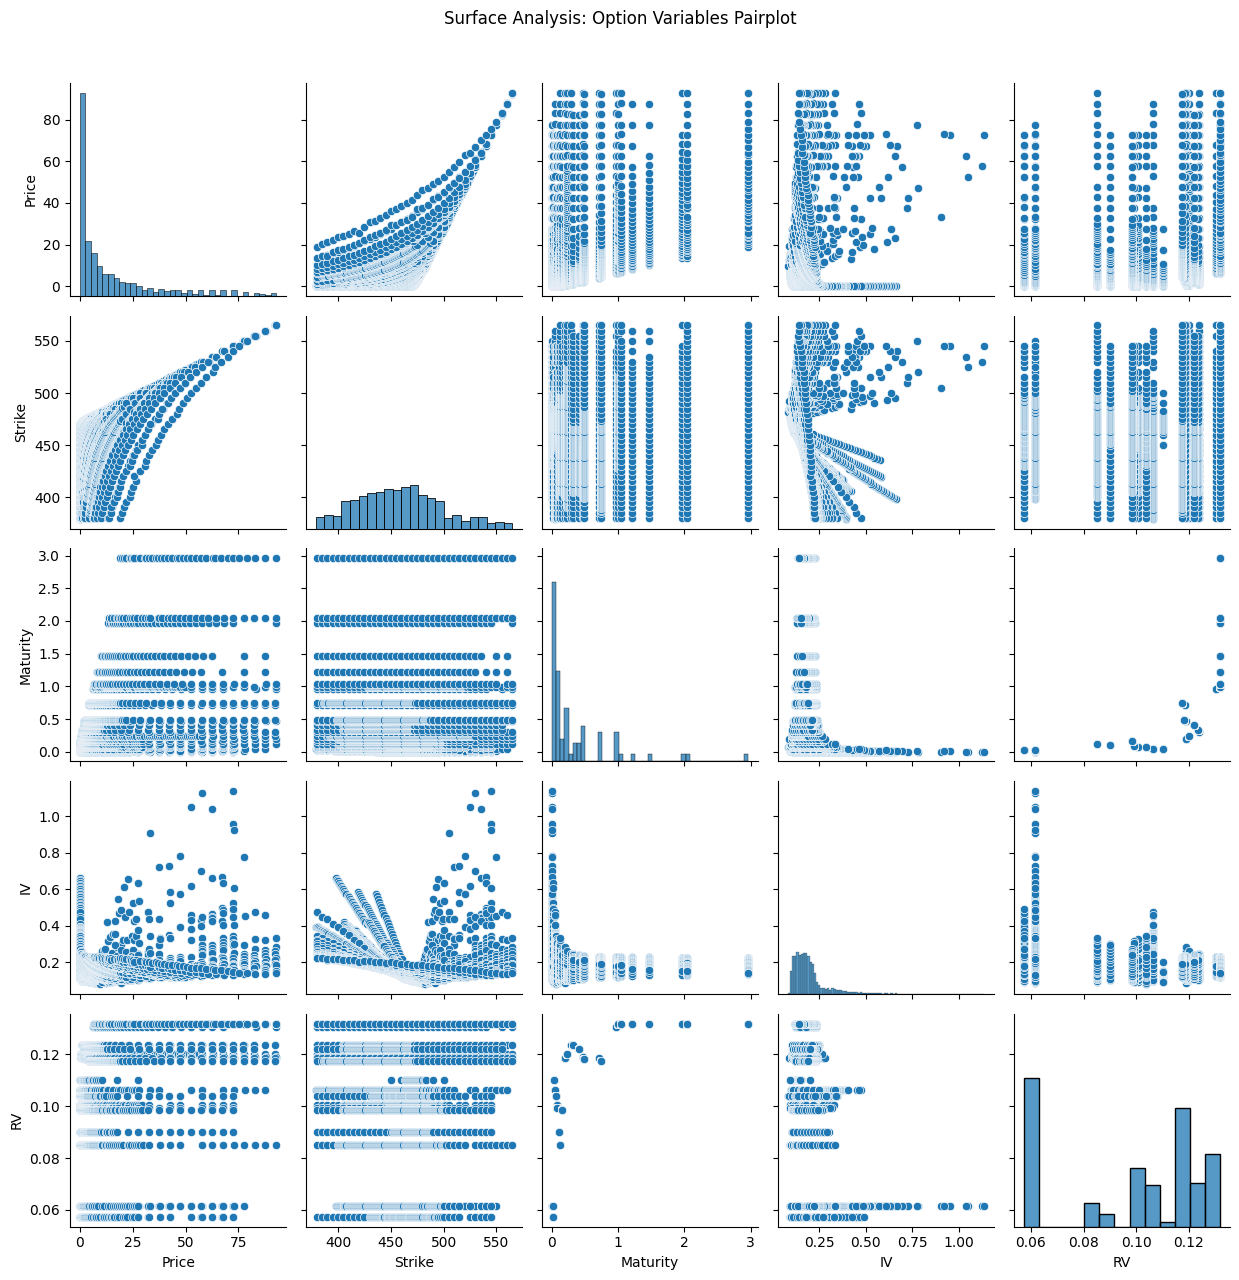

In [64]:
def get_rv(days):
    days = max(int(days), 5) 
    return spy_hist['return'].tail(days).std() * np.sqrt(252)

surface_filtered['RV'] = surface_filtered['T'].apply(lambda t: get_rv(int(t * 252)))

plot_df = surface_filtered[['mid_price', 'strike', 'T', 'impl_volatility', 'RV']].copy()
plot_df.columns = ['Price', 'Strike', 'Maturity', 'IV', 'RV']

sns.pairplot(plot_df, diag_kind='hist')
plt.suptitle('Surface Analysis: Option Variables Pairplot', y=1.02)
plt.tight_layout()
plt.show()

# Result for Surface Analysis
- Price vs Strike: Strong negative relationship (higher strike = OTM put = cheaper)
- Price vs Maturity: Positive relationship (longer maturity = higher time value)
- IV vs Strike: Volatility skew observed (lower strikes show higher IV)
- IV vs Maturity: Short-term options show wider IV dispersion
- IV vs RV: IV generally exceeds RV, indicating variance risk premium
- RV increases with maturity due to mean reversion effect